**DSF Final Project (Barcelona Technology School)**

By: Roberto Arenal 

Data from: 
- https://projects.fivethirtyeight.com/2020-nfl-predictions/

- https://www.kaggle.com/tobycrabtree/nfl-scores-and-betting-data


This project has the intention of giving a prediction of the probability of winning for each game of the actual week of the NFL. 

In [ ]:
import pandas as pd
import numpy as np
import datetime

In [ ]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
import xgboost as xgb
import pickle
import os
import tarfile
import urllib.request

Data is retreived from the FiveThirtyEight web site. Which is a site focused on the analysis of data from different topics. What is of our concern, is the NFL games statistics that this website provides publicly and updates it each week. 

This site provides us the famous **ELO rating system**, which is a method for calculating the relative skill levels of players. If this rating has a considerable correlation with the results, we are using it as our base feature for our prediction model. 

#Data Collection and exploration

In [ ]:
GAMES_ELO_URL = 'https://projects.fivethirtyeight.com/nfl-api/nfl_elo.csv'
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/robretoarenal/DSF_FinalProject/main/"
TEAMS_URL = DOWNLOAD_ROOT + "datasets/nfl_teams.csv"
DS_PATH = os.path.join("Data")

In [ ]:
def fetch_data(teams_url=TEAMS_URL, ds_path=DS_PATH):
  if not os.path.isdir(ds_path):
        os.makedirs(ds_path)

  teams_path = os.path.join(ds_path,'nfl_teams.csv')
  urllib.request.urlretrieve(teams_url, teams_path)

In [ ]:
df=pd.read_csv(GAMES_ELO_URL)
fetch_data()#We will use the nfl_teams.csv data later to merge with df

In [ ]:
df.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,qbelo1_pre,qbelo2_pre,qb1,qb2,qb1_value_pre,qb2_value_pre,qb1_adj,qb2_adj,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2
0,1920-09-26,1920,0,NaN,RII,STP,1503.947,1300.0,0.824651,0.175349,1516.108,1287.838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,0.0
1,1920-10-03,1920,0,NaN,RCH,ABU,1503.420,1300.0,0.824212,0.175788,1510.934,1292.486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.0
2,1920-10-03,1920,0,NaN,BFF,WBU,1478.004,1300.0,0.802000,0.198000,1489.757,1288.247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,6.0
3,1920-10-03,1920,0,NaN,AKR,WHE,1503.420,1300.0,0.824212,0.175788,1515.278,1288.142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,0.0
4,1920-10-03,1920,0,NaN,CBD,PTQ,1504.688,1300.0,0.825267,0.174733,1516.803,1287.885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,0.0


In [ ]:
df.dtypes

date               object
season              int64
neutral             int64
playoff            object
team1              object
team2              object
elo1_pre          float64
elo2_pre          float64
elo_prob1         float64
elo_prob2         float64
elo1_post         float64
elo2_post         float64
qbelo1_pre        float64
qbelo2_pre        float64
qb1                object
qb2                object
qb1_value_pre     float64
qb2_value_pre     float64
qb1_adj           float64
qb2_adj           float64
qbelo_prob1       float64
qbelo_prob2       float64
qb1_game_value    float64
qb2_game_value    float64
qb1_value_post    float64
qb2_value_post    float64
qbelo1_post       float64
qbelo2_post       float64
score1            float64
score2            float64
dtype: object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16810 entries, 0 to 16809
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            16810 non-null  object 
 1   season          16810 non-null  int64  
 2   neutral         16810 non-null  int64  
 3   playoff         590 non-null    object 
 4   team1           16803 non-null  object 
 5   team2           16803 non-null  object 
 6   elo1_pre        16803 non-null  float64
 7   elo2_pre        16803 non-null  float64
 8   elo_prob1       16803 non-null  float64
 9   elo_prob2       16803 non-null  float64
 10  elo1_post       16797 non-null  float64
 11  elo2_post       16797 non-null  float64
 12  qbelo1_pre      14635 non-null  float64
 13  qbelo2_pre      14635 non-null  float64
 14  qb1             14641 non-null  object 
 15  qb2             14640 non-null  object 
 16  qb1_value_pre   14641 non-null  float64
 17  qb2_value_pre   14641 non-null 

In [ ]:
df.isnull().sum()

date                  0
season                0
neutral               0
playoff           16220
team1                 7
team2                 7
elo1_pre              7
elo2_pre              7
elo_prob1             7
elo_prob2             7
elo1_post            13
elo2_post            13
qbelo1_pre         2175
qbelo2_pre         2175
qb1                2169
qb2                2170
qb1_value_pre      2169
qb2_value_pre      2169
qb1_adj            2162
qb2_adj            2162
qbelo_prob1        2169
qbelo_prob2        2169
qb1_game_value     2175
qb2_game_value     2175
qb1_value_post     2175
qb2_value_post     2175
qbelo1_post        2175
qbelo2_post        2175
score1               13
score2               13
dtype: int64

In [ ]:
df.describe()

,season,neutral,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,qbelo1_pre,qbelo2_pre,qb1_value_pre,qb2_value_pre,qb1_adj,qb2_adj,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2
count,16810.000000,16810.000000,16803.000000,16803.000000,16803.000000,16803.000000,16797.000000,16797.000000,14635.000000,14635.000000,14641.000000,14641.000000,14648.000000,14648.000000,14641.000000,14641.000000,14635.000000,14635.000000,14635.000000,14635.000000,14635.000000,14635.000000,16797.000000,16797.000000
mean,1983.619393,0.005473,1502.732847,1499.147750,0.584863,0.415137,1502.461891,1499.351952,1503.993833,1502.722747,94.707190,94.705827,-1.258195,-1.282938,0.574996,0.425004,107.749978,87.192954,95.970935,93.924757,1504.041682,1502.674898,21.615050,18.740013
std,25.872184,0.073779,104.980511,104.417688,0.175244,0.175244,107.539339,106.609134,100.072284,98.863454,57.341477,56.900886,25.000509,25.513945,0.178042,0.178042,133.256457,131.598527,57.632005,57.091094,102.543651,101.095430,11.253972,10.815233
min,1920.000000,0.000000,1119.595000,1156.551000,0.070953,0.029484,1119.595000,1153.902000,1149.699743,1152.474651,-53.778917,-47.286867,-242.487678,-218.568599,0.059810,0.032803,-385.737110,-413.971659,-46.329533,-53.778917,1164.327676,1149.699743,0.000000,0.000000
25%,1968.000000,0.000000,1429.443000,1426.015000,0.460919,0.280314,1426.968000,1424.300000,1433.839345,1434.291131,53.150019,53.477085,-8.230231,-8.074793,0.446664,0.286474,14.615836,-6.202121,53.909725,52.336504,1432.336253,1431.891933,14.000000,10.000000
50%,1988.000000,0.000000,1504.503000,1500.675000,0.596662,0.403338,1504.307000,1500.735000,1505.488774,1504.419126,89.279087,89.678692,1.976468,2.136430,0.586351,0.413649,104.771856,82.731136,90.476700,88.724627,1505.039546,1504.933375,21.000000,17.000000
75%,2005.000000,0.000000,1578.225093,1576.062500,0.719686,0.539081,1580.795000,1577.091000,1574.456540,1574.603216,130.293126,130.022264,12.044192,11.999459,0.713526,0.553336,198.411935,175.515991,131.716330,129.764621,1578.301943,1574.834996,28.000000,26.000000
max,2020.000000,1.000000,1839.663000,1849.484000,0.970516,0.929047,1849.484000,1831.462000,1806.390160,1814.366226,329.562716,327.716545,107.685793,107.087461,0.967197,0.940190,713.695222,605.098179,327.716545,329.562716,1814.366226,1806.223590,72.000000,73.000000


In [ ]:
duplicate_rows_df = df[df.duplicated()]
print('number of duplicate rows: ', duplicate_rows_df.shape)

number of duplicate rows:  (3, 30)


#Data Preparation

In [ ]:
#We dont need games without score. Means they havent passed. 
df = df[df['score1'].notna()]

#Change date dtype to datetime
df['date'] = pd.to_datetime(df['date'])

#Drop columns we know we won't need. Columns with _post are provided after the game result, so they dont help us.  
df = df.drop(columns=['neutral','playoff','elo1_post','elo2_post','qb1','qb2',
                      'qb1_value_post','qb2_value_post','qbelo1_post','qbelo2_post'], axis=1) 

In [ ]:
#Add column of result being 1 a win of home team
df['result'] = (df.score1 >= df.score2).astype(int)

In [ ]:
#Remove null values
#Change data types
## More optional EDA
#pairplot(df)
  

#Feature Selection

##Feature subset 1

In [ ]:
#First, we work with columns that doesn't have nulls
df_sb1 = df[['elo1_pre','elo2_pre','elo_prob1','elo_prob2','result']]

In [ ]:
df_sb1.corr()

,elo1_pre,elo2_pre,elo_prob1,elo_prob2,result
elo1_pre,1.000000,0.083517,0.674071,-0.674071,0.246291
elo2_pre,0.083517,1.000000,-0.670229,0.670229,-0.232654
elo_prob1,0.674071,-0.670229,1.000000,-1.000000,0.354826
elo_prob2,-0.674071,0.670229,-1.000000,1.000000,-0.354826
result,0.246291,-0.232654,0.354826,-0.354826,1.000000


In [ ]:
from statsmodels.graphics.correlation import plot_corr
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 1.0, 'Correlation Heatmap')

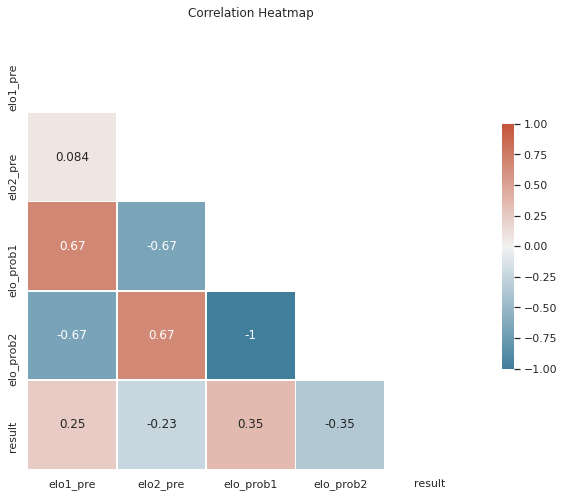

In [ ]:
sns.set_theme(style="white")
corr1=df_sb1.corr()
mask = np.triu(np.ones_like(corr1, dtype=bool))
f, ax = plt.subplots(figsize=(10, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
heatmap=sns.heatmap(corr1, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
heatmap.set_title('Correlation Heatmap')

In [ ]:
#We are gonna drop the features that has high correlation between them. Will choose the one with higher relation with result. 

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

X = df_sb1[['elo1_pre','elo2_pre','elo_prob1','elo_prob2']]
y = df_sb1['result']

# base model
base = LDA()
# choose 3 best features
rfe = RFE(base, 1)
rfe = rfe.fit(X, y)

# features
print(rfe.support_)
print(rfe.ranking_)

[False False False  True]
[3 4 2 1]


In [ ]:
#Drop elo_prob2 since has a high correlation with elo_prob1. Keep elo_prob1 because it corresponds to home team 

##Feature subset 2

In [ ]:
df[df['qbelo1_pre'].isna()].describe()

,season,elo1_pre,elo2_pre,elo_prob1,elo_prob2,qbelo1_pre,qbelo2_pre,qb1_value_pre,qb2_value_pre,qb1_adj,qb2_adj,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,score1,score2,result
count,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2162.000000,2162.000000,2162.000000
mean,1934.543941,1490.228523,1474.201720,0.599030,0.400970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.577243,11.382979,0.649399
std,9.431953,115.501051,117.288435,0.189529,0.189529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.769403,11.430147,0.477269
min,1920.000000,1119.595000,1172.916000,0.074040,0.048223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,1926.000000,1406.569500,1391.261500,0.462854,0.247911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,0.000000,0.000000
50%,1934.000000,1501.893500,1469.762000,0.619609,0.380391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.000000,7.000000,1.000000
75%,1944.000000,1580.134500,1566.578250,0.752089,0.537146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,17.000000,1.000000
max,1949.000000,1791.536000,1804.324000,0.951777,0.925960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.000000,73.000000,1.000000


In [ ]:
#Just work with seasons > 1949 so we can explore the rest of the variables
df_sb2=df.loc[df['season'] > 1949]

In [ ]:
df_sb2.isnull().sum()

date              0
season            0
team1             0
team2             0
elo1_pre          0
elo2_pre          0
elo_prob1         0
elo_prob2         0
qbelo1_pre        0
qbelo2_pre        0
qb1_value_pre     0
qb2_value_pre     0
qb1_adj           0
qb2_adj           0
qbelo_prob1       0
qbelo_prob2       0
qb1_game_value    0
qb2_game_value    0
score1            0
score2            0
result            0
dtype: int64

In [ ]:
df_sb2=df_sb2[['qbelo1_pre','qbelo2_pre','qb1_value_pre','qb2_value_pre','qb1_adj','qb2_adj','qbelo_prob1','qbelo_prob2',
                  'qb1_game_value','qb2_game_value','result']]

In [ ]:
df_sb2.corr()

,qbelo1_pre,qbelo2_pre,qb1_value_pre,qb2_value_pre,qb1_adj,qb2_adj,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,result
qbelo1_pre,1.000000,0.069888,0.459298,0.034179,0.116141,0.017964,0.668882,-0.668882,0.189725,-0.049400,0.240886
qbelo2_pre,0.069888,1.000000,0.043373,0.436970,0.033256,0.093921,-0.640435,0.640435,-0.020537,0.174386,-0.222172
qb1_value_pre,0.459298,0.043373,1.000000,0.275971,0.520033,0.012789,0.376223,-0.376223,0.352388,0.110306,0.137855
qb2_value_pre,0.034179,0.436970,0.275971,1.000000,0.003745,0.523685,-0.369380,0.369380,0.108492,0.345598,-0.141157
qb1_adj,0.116141,0.033256,0.520033,0.003745,1.000000,0.013435,0.229960,-0.229960,0.127696,-0.001010,0.078227
qb2_adj,0.017964,0.093921,0.012789,0.523685,0.013435,1.000000,-0.221653,0.221653,0.005859,0.122840,-0.061187
qbelo_prob1,0.668882,-0.640435,0.376223,-0.369380,0.229960,-0.221653,1.000000,-1.000000,0.169396,-0.178220,0.348883
qbelo_prob2,-0.668882,0.640435,-0.376223,0.369380,-0.229960,0.221653,-1.000000,1.000000,-0.169396,0.178220,-0.348883
qb1_game_value,0.189725,-0.020537,0.352388,0.108492,0.127696,0.005859,0.169396,-0.169396,1.000000,0.092034,0.372571
qb2_game_value,-0.049400,0.174386,0.110306,0.345598,-0.001010,0.122840,-0.178220,0.178220,0.092034,1.000000,-0.366888


In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Correlation Heatmap')

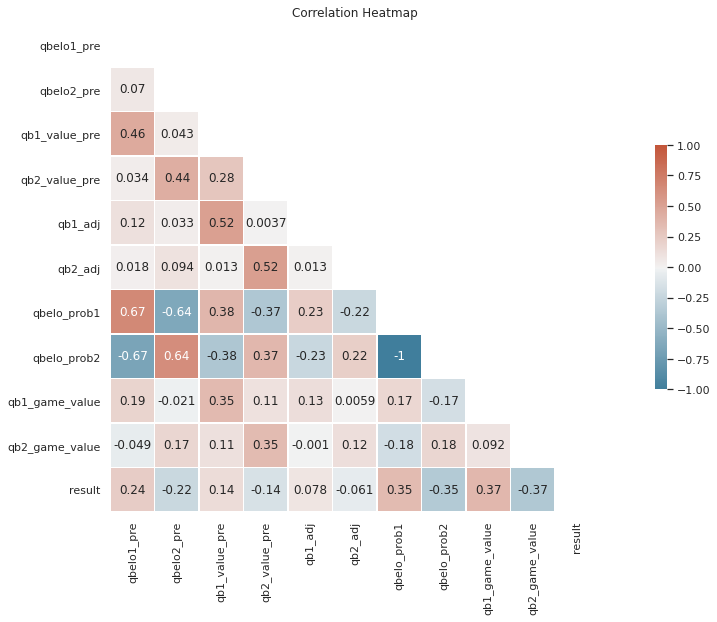

In [ ]:
sns.set_theme(style="white")
corr=df_sb2.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(20, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
heatmap=sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
heatmap.set_title('Correlation Heatmap')

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

X = df_sb2[['qbelo1_pre','qbelo2_pre','qb1_value_pre','qb2_value_pre','qb1_adj','qb2_adj','qbelo_prob1','qbelo_prob2',
                  'qb1_game_value','qb2_game_value']]
y = df_sb2['result']

# base model
base = LDA()
# choose 3 best features
rfe = RFE(base, 1)
rfe = rfe.fit(X, y)

# features
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False  True False False False]
[ 8  9  5  6  7 10  1  2  3  4]


In [ ]:
#Drop qbelo_prob2 since has a high correlation with elo_prob1. Keep qbelo_prob1 because it corresponds to home team.
#Drop qb1_adj and qb2_adj because they correlate very low with result. 


##Feature subsets 3

In [ ]:
#Plot a correlation heatmap of the two previous subsets

df_sb3 = df.loc[df['season'] > 1949]
df_sb3 = df_sb3 [['elo1_pre','elo2_pre','elo_prob1','qbelo1_pre','qbelo2_pre','qb1_value_pre','qb2_value_pre','qbelo_prob1',
                  'qb1_game_value','qb2_game_value','result']]

In [ ]:
df_sb3.isna().sum()

elo1_pre          0
elo2_pre          0
elo_prob1         0
qbelo1_pre        0
qbelo2_pre        0
qb1_value_pre     0
qb2_value_pre     0
qbelo_prob1       0
qb1_game_value    0
qb2_game_value    0
result            0
dtype: int64

Text(0.5, 1.0, 'Correlation Heatmap')

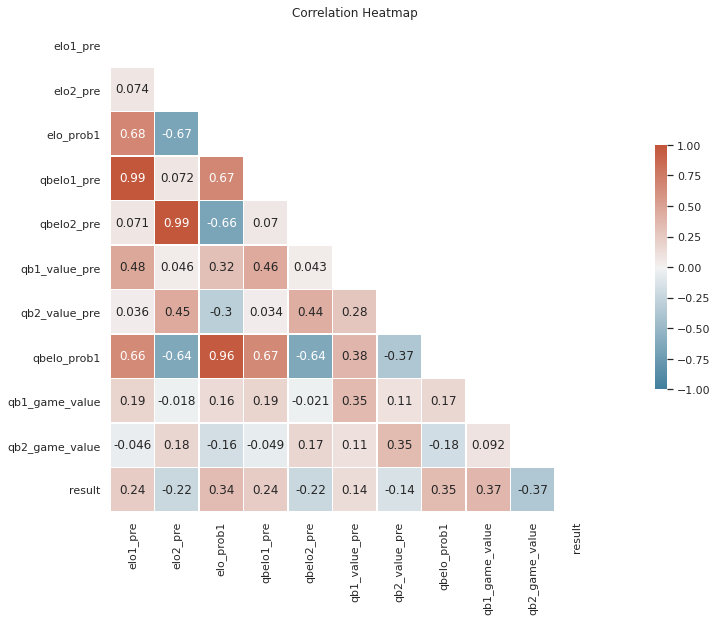

In [ ]:
sns.set_theme(style="white")
corr3=df_sb3.corr()
mask = np.triu(np.ones_like(corr3, dtype=bool))
f, ax = plt.subplots(figsize=(20, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
heatmap=sns.heatmap(corr3, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
heatmap.set_title('Correlation Heatmap')

In [ ]:
#Drop elo1_pre because has .99 of correlation with qbelo1_pre and second one has higher correlation with result. Same for elo2_pre and qbelo2_pre
#Drop qb1_value_pre and qb2_value_pre because they just have .14 of correlation with result. 
#Drop elo_prob1 because has a very high correlation with qbelo_prob1 and second one is higher correlated to result. 

#First modeling

In [ ]:
df_me = df.loc[df['season'] > 1949]
df_me = df_me[['qbelo1_pre','qbelo2_pre','qbelo_prob1',
                  'qb1_value_pre','qb2_value_pre','result']]

In [ ]:
X = df_me[['qbelo1_pre','qbelo2_pre','qbelo_prob1','qb1_value_pre','qb2_value_pre']]
y = df_me['result']

In [ ]:
RFC = RandomForestClassifier(random_state=0, n_estimators=100)

In [ ]:
kfold = model_selection.KFold(n_splits=5, random_state=0)
cv_results = model_selection.cross_val_score(RFC, X, y, cv=kfold, scoring = 'roc_auc')
msg = "%f (%f)" % (cv_results.mean(), cv_results.std())
print(msg)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.666343 (0.013636)


In [ ]:
train = df.copy()
test = df.copy()
train = train.loc[(train['season'] > 1949) & (train['season'] < 2017)]
test = test.loc[test['season'] > 2016]

In [ ]:
X_train=train[['qbelo1_pre','qbelo2_pre','qbelo_prob1','qb1_value_pre','qb2_value_pre']]
y_train = train['result']

X_test = test[['qbelo1_pre','qbelo2_pre','qbelo_prob1','qb1_value_pre','qb2_value_pre']]
y_test = test['result']

In [ ]:
X_train.shape

(13578, 5)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
RFG = RandomForestRegressor(n_estimators=100, random_state=42)

In [ ]:
RFG.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

##Evaluation

In [ ]:
results = RFG.predict(X_test)

In [ ]:
test.loc[:,'hm_prob'] = results
test = test[['season', 'team1', 'team2', 'hm_prob', 'result']]
# calulate bets won (only make a bet when probability is greater than / equal to 60% or less than / equal to 40%)
test['my_bet_won'] = (((test.hm_prob >= 0.60) & (test.result == 1)) | ((test.hm_prob <= 0.40) & (test.result == 0))).astype(int)
# calulate bets lost (only make a bet when probability is greater than / equal to 60% or less than / equal to 40%)
test['my_bet_lost'] = (((test.hm_prob >= 0.60) & (test.result == 0)) | ((test.hm_prob <= 0.40) & (test.result == 1))).astype(int)

In [ ]:
# printing some quick overall results for my model
print("My Model Win Percentage: " + "{:.4f}".format(test.my_bet_won.sum() / (test.my_bet_lost.sum() + test.my_bet_won.sum())))
print("Total Number of Bets Won: " + str(test.my_bet_won.sum()))
print("Total Number of Bets Made: " + str((test.my_bet_lost.sum() + test.my_bet_won.sum())))
print("Possible Games: " + str(len(test)))

My Model Win Percentage: 0.6537
Total Number of Bets Won: 470
Total Number of Bets Made: 719
Possible Games: 1057


#Feature Creation

Here we want to create 3 new features to help us imporove the result prediction. These are the following: 

- avg_diff: the average of the total point difference in the season.
- avg_pts: average of total points scored in the season. 
- avg_against_pts: average of total points received in the season. 

In [ ]:
df1 = df.copy()

In [ ]:
#Create new table with one row per team per game.
games = df.groupby(['season','date', 'team1']).mean()[['score1', 'score2']].reset_index()
aw_games = df.groupby(['season','date', 'team2']).mean()[['score1', 'score2']].reset_index()
games['point_diff'] = games.score1 - games.score2
aw_games['point_diff'] = aw_games.score2 - aw_games.score1
# append the two dataframes
games = games.append(aw_games, ignore_index=True, sort=True)

# fill null values
games.team1.fillna(games.team2, inplace=True)

# sort by season and week
games.sort_values(['date'], ascending = [True], inplace=True)
# removing unneeded columns & changing column name
games = games[['season','date', 'team1', 'score1', 'score2', 'point_diff']]
games.rename(columns={'team1' : 'team'}, inplace=True)

In [ ]:
#Creating a dict of dataframes for each team
tm_dict = {}

for key in games.team.unique():
  tm_dict[key] = games[games.team == key].reset_index(drop=True)

In [ ]:
pts_diff = pd.DataFrame()

for yr in games.season.unique():
  #print(yr)
  for tm in games.team.unique():
    #print(tm)
    data = tm_dict[tm].copy()
    data = data[data.season == yr]
    data.loc[:, 'avg_pts_diff'] = data.point_diff.shift().expanding().mean()
    data.loc[:, 'total_pts'] = data.score1.shift().expanding().mean()
    data.loc[:, 'total_against_pts'] = data.score2.shift().expanding().mean()
    pts_diff = pts_diff.append(data)

In [ ]:
#Add week column just for first week of season(NaNs)
pts_diff.loc[(pts_diff.avg_pts_diff.isna()),'Week'] = 1
pts_diff.Week.fillna(0, inplace=True)
pts_diff['Week'] = pts_diff['Week'].astype(int)

#Create 3 different dataFrames to group by each stat.
total_season = pts_diff.groupby(['season','team']).mean()['score1'].reset_index()
total_season2= pts_diff.groupby(['season','team']).mean()['score2'].reset_index()
total_season3 = pts_diff.groupby(['season','team']).mean()['point_diff'].reset_index()

In [ ]:
#Merge the 3 different grouped by stats (score1, score2, point_diff) and rename them (total_pts, total_against_pts, avg_pts_diff)
total_season = total_season.merge(total_season2[['season','team','score2']],
                                  left_on=['season','team'], right_on=['season','team'], how='left')

total_season = total_season.merge(total_season3[['season','team','point_diff']],
                                  left_on=['season','team'], right_on=['season','team'], how='left')

total_season.rename(columns={'score1' : 'total_pts'}, inplace=True)
total_season.rename(columns={'score2' : 'total_against_pts'}, inplace=True)
total_season.rename(columns={'point_diff' : 'avg_pts_diff'}, inplace=True)

#Add Week = 1 column and pass to next season so it be the weeks 1 stat
total_season['Week'] = 1
total_season['season'] += 1

#Merge
pts_diff = pts_diff.merge(total_season[['season','team','Week','total_pts','total_against_pts','avg_pts_diff']],
                          left_on=['season','team','Week'],
                          right_on=['season','team','Week'], how='left')

pts_diff.avg_pts_diff_x.fillna(pts_diff.avg_pts_diff_y, inplace=True)
pts_diff.total_pts_x.fillna(pts_diff.total_pts_y, inplace=True)
pts_diff.total_against_pts_x.fillna(pts_diff.total_against_pts_y, inplace=True)
#drop _y columns and rename _x columns
pts_diff.drop(columns=['avg_pts_diff_y','total_pts_y','total_against_pts_y'], inplace=True)
pts_diff.columns = pts_diff.columns.str.replace('_x', '')

In [ ]:
#merge new attributes to the original dataframe. For both home and away teams.
df1 = df1.merge(pts_diff[['season','date','team','avg_pts_diff','total_pts','total_against_pts']],
      left_on=['season','date','team1'],
      right_on=['season','date','team'], how='left')
df1.rename(columns={'avg_pts_diff' : 'hm_avg_diff'}, inplace=True)
df1.rename(columns={'total_pts' : 'hm_avg_pts'}, inplace=True)
df1.rename(columns={'total_against_pts' : 'hm_avg_against_pts'}, inplace=True)

df1 = df1.merge(pts_diff[['season','date','team','avg_pts_diff','total_pts','total_against_pts']],
      left_on=['season','date','team2'],
      right_on=['season','date','team'], how='left')
df1.rename(columns={'avg_pts_diff' : 'aw_avg_diff'}, inplace=True)
df1.rename(columns={'total_pts' : 'aw_avg_pts'}, inplace=True)
df1.rename(columns={'total_against_pts' : 'aw_avg_against_pts'}, inplace=True)

In [ ]:
df1.tail(10)

,date,season,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,qbelo1_pre,qbelo2_pre,qb1_value_pre,qb2_value_pre,qb1_adj,qb2_adj,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,score1,score2,result,team_x,hm_avg_diff,hm_avg_pts,hm_avg_against_pts,team_y,aw_avg_diff,aw_avg_pts,aw_avg_against_pts
16787,2021-01-03,2020,CIN,BAL,1382.193725,1637.701017,0.250368,0.749632,1416.857420,1640.537594,62.876847,249.500009,-78.305602,13.807112,0.165461,0.834539,-138.770731,250.156648,3.0,38.0,0,CIN,-5.200000,25.600000,20.666667,BAL,8.666667,25.933333,22.733333
16788,2021-01-03,2020,SF,SEA,1494.784619,1617.482789,0.417721,0.582279,1513.721342,1609.205246,102.850851,204.114710,-20.681589,-2.837338,0.390153,0.609847,172.799305,157.993876,23.0,26.0,0,SF,-0.733333,20.133333,27.666667,SEA,5.666667,28.066667,24.000000
16789,2021-01-03,2020,IND,JAX,1592.832646,1260.258714,0.907930,0.092070,1589.274905,1259.472090,179.525964,106.567090,10.841613,-10.082140,0.902476,0.097524,35.239772,72.949034,28.0,14.0,1,IND,5.000000,25.000000,26.400000,JAX,-11.466667,24.133333,26.266667
16790,2021-01-03,2020,KC,LAC,1777.933310,1427.636782,0.916111,0.083889,1757.263199,1426.672867,86.419144,186.524342,-178.353835,15.254958,0.733018,0.266982,236.702023,317.173593,21.0,38.0,0,KC,8.533333,25.533333,26.200000,LAC,-3.933333,24.600000,25.466667
16791,2021-01-03,2020,HOU,TEN,1405.446866,1590.293046,0.334058,0.665942,1379.429399,1563.617486,251.762944,214.182197,22.408442,13.054897,0.309814,0.690186,224.752531,241.915792,38.0,41.0,0,HOU,-5.133333,26.266667,25.000000,TEN,3.266667,29.200000,27.533333
16792,2021-01-03,2020,DEN,OAK,1430.051399,1449.188398,0.565621,0.434379,1436.714473,1459.179311,103.818316,189.686666,10.185265,0.349403,0.532775,0.467225,216.114816,136.534184,31.0,32.0,0,DEN,-8.133333,21.200000,25.866667,OAK,-3.000000,28.333333,28.266667
16793,2021-01-03,2020,CAR,NO,1416.879291,1681.113286,0.241059,0.758941,1431.820760,1718.441448,176.810004,225.026845,14.638327,0.930206,0.203252,0.796748,-16.099728,197.627645,7.0,33.0,0,CAR,-1.733333,23.466667,24.000000,NO,7.933333,25.666667,26.266667
16794,2021-01-03,2020,CHI,GB,1521.382026,1678.962501,0.369832,0.630168,1516.512893,1655.433657,156.935460,257.967788,15.128915,25.227266,0.339926,0.660074,235.974167,344.789454,16.0,35.0,0,CHI,1.400000,23.200000,22.866667,GB,8.066667,30.000000,25.133333
16795,2021-01-03,2020,LAR,ARI,1573.922178,1491.090011,0.700775,0.299225,1562.745220,1472.139393,28.112040,253.223925,-142.170953,28.505249,0.434655,0.565345,106.453285,57.217468,18.0,7.0,1,LAR,4.333333,22.400000,20.466667,ARI,3.600000,23.466667,26.666667
16796,2021-01-03,2020,PHI,WSH,1409.246198,1434.907496,0.556372,0.443628,1410.872779,1435.271322,129.237211,117.671499,-4.709325,31.183061,0.461457,0.538543,32.161337,3.902425,14.0,20.0,0,PHI,-5.200000,26.000000,21.866667,WSH,0.000000,20.600000,21.400000


##Correlation of new features

In [ ]:
df1.tail(2)

In [ ]:
df_sb4 = df1[['qbelo1_pre','qbelo2_pre','qbelo_prob1','hm_avg_diff','hm_avg_pts','hm_avg_against_pts',
               'aw_avg_diff','aw_avg_pts','aw_avg_against_pts','result']]

In [ ]:
df_sb4.corr()

,qbelo1_pre,qbelo2_pre,qbelo_prob1,hm_avg_diff,hm_avg_pts,hm_avg_against_pts,aw_avg_diff,aw_avg_pts,aw_avg_against_pts,result
qbelo1_pre,1.000000,0.069888,0.668882,0.737506,0.004619,0.071105,0.031721,-0.023696,0.000852,0.240886
qbelo2_pre,0.069888,1.000000,-0.640435,0.039150,0.016110,-0.025280,0.731784,0.109893,-0.045596,-0.222172
qbelo_prob1,0.668882,-0.640435,1.000000,0.518383,0.001755,0.080813,-0.501319,-0.113210,0.016045,0.348883
hm_avg_diff,0.737506,0.039150,0.518383,1.000000,-0.040526,0.038241,0.025923,-0.050729,-0.041895,0.220551
hm_avg_pts,0.004619,0.016110,0.001755,-0.040526,1.000000,0.332757,0.025589,0.269320,0.293345,-0.038452
hm_avg_against_pts,0.071105,-0.025280,0.080813,0.038241,0.332757,1.000000,-0.003543,0.297493,0.387655,-0.008404
aw_avg_diff,0.031721,0.731784,-0.501319,0.025923,0.025589,-0.003543,1.000000,0.105740,-0.029248,-0.187795
aw_avg_pts,-0.023696,0.109893,-0.113210,-0.050729,0.269320,0.297493,0.105740,1.000000,0.318195,-0.067019
aw_avg_against_pts,0.000852,-0.045596,0.016045,-0.041895,0.293345,0.387655,-0.029248,0.318195,1.000000,-0.034347
result,0.240886,-0.222172,0.348883,0.220551,-0.038452,-0.008404,-0.187795,-0.067019,-0.034347,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

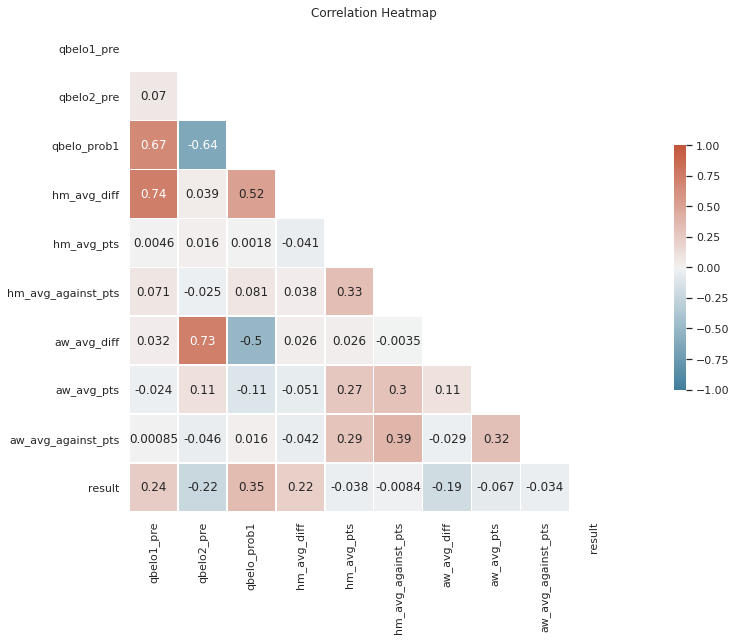

In [ ]:
sns.set_theme(style="white")
corr4=df_sb4.corr()
mask = np.triu(np.ones_like(corr4, dtype=bool))
f, ax = plt.subplots(figsize=(20, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
heatmap=sns.heatmap(corr4, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
heatmap.set_title('Correlation Heatmap')

In [ ]:
#Discard the features avg_points and avg_against_pts because they have low correlation with result

#Second modeling

In [ ]:
df1.head()

,date,season,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,qbelo1_pre,qbelo2_pre,qb1_value_pre,qb2_value_pre,qb1_adj,qb2_adj,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,score1,score2,result,team_x,hm_avg_diff,hm_avg_pts,hm_avg_against_pts,team_y,aw_avg_diff,aw_avg_pts,aw_avg_against_pts
0,1920-09-26,1920,RII,STP,1503.947,1300.0,0.824651,0.175349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,0.0,1,RII,NaN,NaN,NaN,STP,NaN,NaN,NaN
1,1920-10-03,1920,RCH,ABU,1503.420,1300.0,0.824212,0.175788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.0,1,RCH,NaN,NaN,NaN,ABU,NaN,NaN,NaN
2,1920-10-03,1920,BFF,WBU,1478.004,1300.0,0.802000,0.198000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,6.0,1,BFF,NaN,NaN,NaN,WBU,NaN,NaN,NaN
3,1920-10-03,1920,AKR,WHE,1503.420,1300.0,0.824212,0.175788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,0.0,1,AKR,NaN,NaN,NaN,WHE,NaN,NaN,NaN
4,1920-10-03,1920,CBD,PTQ,1504.688,1300.0,0.825267,0.174733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,0.0,1,CBD,NaN,NaN,NaN,PTQ,NaN,NaN,NaN


In [ ]:
train = df1.copy()
test = df1.copy()
train = train.loc[(train['season'] > 1949) & (train['season'] < 2017)]
test = test.loc[test['season'] > 2016]

In [ ]:
train = train[train['hm_avg_diff'].notna()]
train = train[train['aw_avg_diff'].notna()]
train.isna().sum()

In [ ]:
X_train=train[['qbelo1_pre','qbelo2_pre','qbelo_prob1','qb1_value_pre','qb2_value_pre','hm_avg_diff','aw_avg_diff']]
y_train = train['result']

X_test = test[['qbelo1_pre','qbelo2_pre','qbelo_prob1','qb1_value_pre','qb2_value_pre','hm_avg_diff','aw_avg_diff']]
y_test = test['result']

In [ ]:
from sklearn.ensemble import RandomForestRegressor
RFG = RandomForestRegressor(n_estimators=100, random_state=42)

In [ ]:
RFG.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

##Evaluation

In [ ]:
results = RFG.predict(X_test)

In [ ]:
test.loc[:,'hm_prob'] = results
test = test[['season', 'team1', 'team2', 'hm_prob', 'result']]
# calulate bets won (only make a bet when probability is greater than/equal to 60% or less than/equal to 40%)
test['my_bet_won'] = (((test.hm_prob >= 0.60) & (test.result == 1)) | ((test.hm_prob <= 0.40) & (test.result == 0))).astype(int)
# calulate bets lost
test['my_bet_lost'] = (((test.hm_prob >= 0.60) & (test.result == 0)) | ((test.hm_prob <= 0.40) & (test.result == 1))).astype(int)

In [ ]:
# printing some quick overall results for my model
print("My Model Win Percentage: " + "{:.4f}".format(test.my_bet_won.sum() / (test.my_bet_lost.sum() + test.my_bet_won.sum())))
print("Total Number of Bets Won: " + str(test.my_bet_won.sum()))
print("Total Number of Bets Made: " + str((test.my_bet_lost.sum() + test.my_bet_won.sum())))
print("Possible Games: " + str(len(test)))

My Model Win Percentage: 0.6817
Total Number of Bets Won: 452
Total Number of Bets Made: 663
Possible Games: 1057


In [ ]:
#63.78 % win percentage without new feat
#68.17 % win percentage qb_value_pre y qbelo_prob1. With new features, the model improved 5%. 

##Evaluation with Scaled features

In [ ]:
from sklearn.preprocessing import StandardScaler

ss=StandardScaler()
ss2=StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss2.fit_transform(X_test)

In [ ]:
X_train_sc = pd.DataFrame(
    X_train_sc,
    columns=list(X_train.columns),
    index=X_train.index)

X_test_sc = pd.DataFrame(
    X_test_sc,
    columns=list(X_test.columns),
    index=X_test.index)

X_train_sc.head()

,qbelo1_pre,qbelo2_pre,qbelo_prob1,qb1_value_pre,qb2_value_pre,hm_avg_diff,aw_avg_diff
2162,1.684760,1.423541,0.251768,-1.656434,-1.669764,2.140504,1.509183
2163,0.609986,1.265454,-0.483286,-1.656434,-1.669764,0.933782,1.029432
2164,-0.180561,-0.404399,0.207380,-1.656434,-1.669764,0.086727,-0.156394
2165,-1.490506,-0.532423,-0.741403,-1.656434,-1.669764,-2.060270,-0.260747
2166,0.869190,-1.820445,1.670122,-1.656434,-1.669764,1.504427,-2.091662


In [ ]:
RFG_scaled = RandomForestRegressor(n_estimators=100, random_state=42)

In [ ]:
RFG_scaled.fit(X_train_sc,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
results = RFG_scaled.predict(X_test_sc)

In [ ]:
test.loc[:,'hm_prob'] = results
test = test[['season', 'team1', 'team2', 'hm_prob', 'result']]
# calulate bets won (only make a bet when probability is greater than/equal to 60% or less than/equal to 40%)
test['my_bet_won'] = (((test.hm_prob >= 0.60) & (test.result == 1)) | ((test.hm_prob <= 0.40) & (test.result == 0))).astype(int)
# calulate bets lost
test['my_bet_lost'] = (((test.hm_prob >= 0.60) & (test.result == 0)) | ((test.hm_prob <= 0.40) & (test.result == 1))).astype(int)

In [ ]:
# printing some quick overall results for my model
print("My Model Win Percentage: " + "{:.4f}".format(test.my_bet_won.sum() / (test.my_bet_lost.sum() + test.my_bet_won.sum())))
print("Total Number of Bets Won: " + str(test.my_bet_won.sum()))
print("Total Number of Bets Made: " + str((test.my_bet_lost.sum() + test.my_bet_won.sum())))
print("Possible Games: " + str(len(test)))

My Model Win Percentage: 0.6807
Total Number of Bets Won: 501
Total Number of Bets Made: 736
Possible Games: 1057


In [ ]:
#68.07 % win percentage with scaled features vs 68.17% without scaled features. 